# Performance evaluation and benchmarking

In this notebook we will go step-by-step through the model evaluation part of our paper, as well as through the benchmarking part, where we compare our simulation results with a good hand-full of different (well-established) hydrological models.

For more information read the experiment description in our paper:

**TODO**: Include Ref

Note:
If you want to run this notebook locally and reproduce the figures of our paper
- make sure you have our pre-trained models. See the [README.md](link) in the repository for further instructions.

- make sure to have the CAMELS benchmark data set. See the [README.md](link) in the repository for further instructions.

#### Adapt the lines below according to your local system

In [1]:
# Needed if no precomputed results are used. Main directory containing all runs
BASE_RUN_DIR = "C:/Users/vivie/srp/ealstm/runs"

# Path to the benchmark model folders containing the basin netCDF files
# Adaptation: I am not using one!
BENCHMARK_DIR = "/datadisk/data/CAMELS/benchmark_models/combined/netcdf/"

# Path to the main directory of this repository
BASE_CODE_DIR = "C:/Users/vivie/srp/ealstm"

In [2]:
# Imports
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import pandas as pd
import tqdm
from scipy.stats import wilcoxon

# Add repository to Python path
sys.path.append(BASE_CODE_DIR)
from papercode.plotutils import model_draw_style, model_specs, ecdf
from papercode.evalutils import (get_run_dirs, eval_lstm_models, 
                                 eval_benchmark_models, get_pvals, 
                                 get_mean_basin_performance, get_cohens_d)
from papercode.metrics import *
import glob, os

Definition of global variables. 

**Note**: If you want to recompute all model metrics, change the `PRECOMPUTED_DATA` flag to `False`. No GPU is required. If you want to use the pre-calculated metrics, make sure the flag is set to `True`

In [16]:
# If True load pre-computed metrics from pickle file, else re-calculate everything
PRECOMPUTED_DATA = False

# Convert to PosixPaths
BASE_RUN_DIR = Path(BASE_RUN_DIR)
#BENCHMARK_DIR = Path(BENCHMARK_DIR)

# Set of evaluation functions
"""EVAL_FUNCS = {'NSE': calc_nse, 
              'alpha_nse': calc_alpha_nse, 
              'beta_nse': calc_beta_nse,
              'FHV': calc_fdc_fhv, 
              'FLV': calc_fdc_flv, 
              'FMS': calc_fdc_fms}"""

EVAL_FUNCS = {'rmse': calc_rmse, 
              'me': calc_me, 
              'correlation': calc_corr,
             #'mse': calc_mse
             }

# Evaluate LSTM-based models

First, we compare the 6 different settings of LSTM-based models, that we trained for this paper. These are three different model settings:

1. EA-LSTM: Our proposed adaption of the LSTM recurrent neural network, where the static catchment characteristics are used to modulate the input gate.
2. LSTM: The standard LSTM architecture, where the static catchment characteristics are concatenated to the meterological inputs at each time step.
3. LSTM (no static inputs): A standard LSTM that is only trained using the meteorological forcing data.

All three model configurations were trained using two different loss functions:

1. MSELoss: The standard mean squared error loss.
2. NSELoss: Our proposed loss function, which approximates the basin averaged NSE. For more details see the Method section of our manuscript.

For each of the 6 settings, we trained 8 models (using different random initializations) and furthermore combined these 8 models to an ensemble (by averaging the k=8 model simulations)

In [17]:
if PRECOMPUTED_DATA:
    print("Loaded data from pre-computed pickle file")
    with open("all_metrics.p", "rb") as fp:
        all_metrics = pickle.load(fp)
else:
    all_metrics = {}
    for func_name, func in EVAL_FUNCS.items():
        tqdm.tqdm.write(f"Calculating metric: {func_name}")
        model_metrics = {}
        """for model, specs in model_specs.items():
            run_dirs = get_run_dirs(root_dir=BASE_RUN_DIR, model=specs["model"], loss=specs["loss"])
            model_metrics[model] = eval_lstm_models(run_dirs=run_dirs, func=func)"""
        seqlens = [1, 7, 14, 21, 30]
        for seqlen in seqlens:
            seqlenstr = 'seqlen' + str(seqlen)
            path = Path('C:/Users/vivie/srp/ealstm/runs/putting this away/run_' + seqlenstr + '_seed11111')
            run_dirs=[path]
            model_metrics[seqlenstr] = eval_lstm_models(run_dirs=run_dirs, func=func)
        """run_dirs = []
        count = 1
        for file in glob.glob("C:/Users/vivie/srp/ealstm/runs/run*"):
            print(file)
            path = Path(file)
            run_dirs.append(path)
            model_metrics["set" + str(count)] = eval_lstm_models(run_dirs=run_dirs, func=func)
            count = count + 1
        all_metrics[func_name] = model_metrics
    with open('all_metrics.p', 'wb') as fp:
        pickle.dump(all_metrics, fp, protocol=pickle.HIGHEST_PROTOCOL)"""
        all_metrics[func_name] = model_metrics

  0%|          | 0/1 [00:00<?, ?it/s]

Calculating metric: rmse


  0%|          | 0/1 [00:00<?, ?it/s]

Calculating metric: me


  0%|          | 0/1 [00:00<?, ?it/s]

Calculating metric: correlation


C:\Users\vivie\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\vivie\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


In [6]:
#print(type(all_metrics))
from sklearn.metrics import mean_squared_error
count = 1
for fips in all_metrics:
    tmp = all_metrics[fips]
    corr = tmp['qobs'].corr(tmp['qsim'])
    rmse = mean_squared_error(y_true = tmp['qobs'], y_pred = tmp['qsim']) ** 0.5
    tmp_results = pd.DataFrame({'fips' : [fips], 'corr' : [corr], 'count' : [count], 'rmse' : [rmse]})
    #print(tmp_results)
    if count == 1:
        results = tmp_results
    else:
        results = pd.concat([results, tmp_results])
    count = count + 1
    #tmp = pd.read_csv(StringData, )
#print(all_metrics)
results = results.loc[results['rmse'] < 250]
results

,fips,corr,count,rmse
0,01133,0.255023,1,3.546626
0,01069,0.103150,2,22.613380
0,01099,0.056628,3,6.558957
0,01117,0.295350,4,38.297621
0,01055,-0.154635,5,35.858227
...,...,...,...,...
0,56029,0.085288,833,2.112128
0,56005,-0.122986,834,3.657106
0,56037,0.022577,835,3.321403
0,56011,-0.101398,836,0.941334


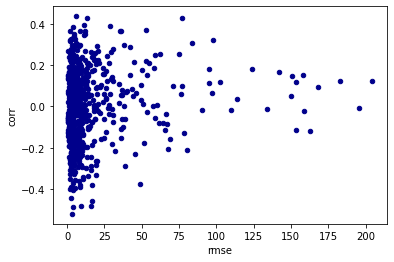

In [88]:
ax1 = results.plot.scatter(x='rmse',
                      y='corr',
                      c='DarkBlue')

In [ ]:
## Tabular comparison

In a first step, we look at the mean, median NSE as well as the number of catastrophic failures. Catastrophic failures are defined as the number of basins, where the model has a NSE <= 0.
We calculate the mean of each of this three statistics over the model (n=8) model repetitions and report the standard deviation here as well. The repetitions are denoted as `ensemble=False` in the table below.

In [38]:
data = []
for model_type, models in all_metrics["rmse"].items():
    if model_type == "benchmarks":
        continue
    seeds = [k for k in models.keys() if "seed" in k]
    means, medians, failures = [], [], []
    for seed in seeds:
        nses = list(models[seed].values())
        means.append(np.mean(nses))
        medians.append(np.median(nses))
        failures.append(len([v for v in nses if v <= 0]))
    data_sing = {'model_type': model_draw_style[model_type]["label"], 
                 'ensemble': False, 
                 'mean': np.mean(means), 
                 'std_mean': np.std(means),
                 'median': np.mean(medians),
                 'std_median': np.std(medians),
                 'failures': np.mean(failures),
                 'std_failures': np.std(failures)}
    data.append(data_sing)
    values = list(models["ensemble"].values())
    data_ensemble = {'model_type': model_draw_style[model_type]["label"],
                   'ensemble': True,
                   'mean': np.mean(values),
                   'median': np.median(values),
                   'failures': len([v for v in values if v < 0]) }
    data.append(data_ensemble)

df = pd.DataFrame(data)
df = df.set_index(keys=["model_type", "ensemble"])
df

KeyError: 'NSE'

## Cumulative density function plot

Here we look at the CDF of the NSEs for each of our 6 configurations. 

- `solid` lines mark models trained with `NSELoss`, `dashed` lines mark models trained with `MSELoss`
- `saturated colors` are ensemble (n=8) means, `non-saturated colors` is a single model. Here we took seed 111 of each model, which is rather arbitrary but from the table above we seed that the mean/median NSE are robust between different random initializations.
- `square` marker denote models trained with static features, while `triangle` markers denote models trained without static features
- `green` is our proposed `EA-LSTM`, `orange` the standard LSTM with static features and `purple` the standard LSTM trained only on meteorological forcing data.

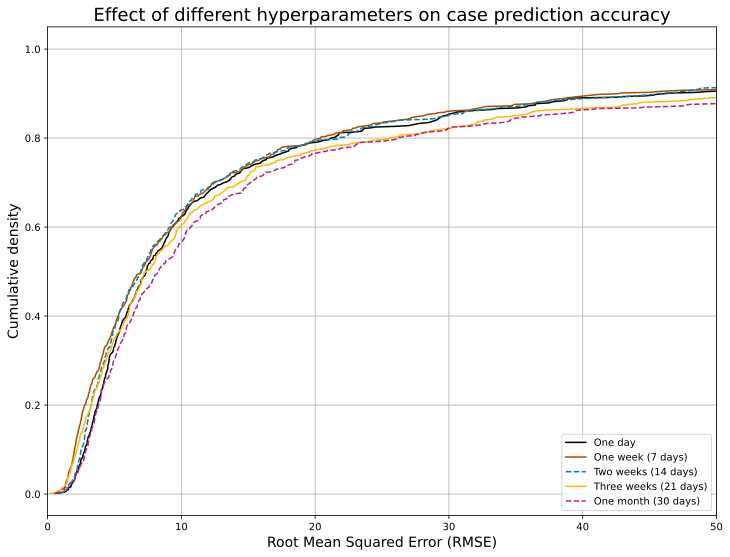

In [6]:
fig, ax = plt.subplots(figsize=(12,9))

for model_type, models in all_metrics["rmse"].items():
    #print("yuss")
    #print(model_type)
    #if 'lstm' in model_type:
    if True:
        # single seed
        values = list(models['seed11111'].values())
        #print(values)
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=model_draw_style[model_type]['label'],
                color=model_draw_style[model_type]["single_color"], 
                #marker=model_draw_style[model_type]['marker'], 
                #markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
      # ensemble seed
#        values = list(models['ensemble'].values())
 #       bin_, cdf_ = ecdf(values)
  #      ax.plot(bin_,
   #             cdf_, 
    #            label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
     #           color=model_draw_style[model_type]['ensemble_color'], 
      #          linestyle=model_draw_style[model_type]['linestyle'])
    
ax.set_xlim(0, 50)
ax.grid(True)
ax.legend(loc='lower right')
ax.set_xlabel('Root Mean Squared Error (RMSE)', fontsize=14)
ax.set_ylabel('Cumulative density', fontsize=14)
ax.set_title("Effect of different hyperparameters on case prediction accuracy", fontsize=18)
fig.savefig("rmse_seqlens.png", bbox_inches='tight', dpi=300)

KeyError: 'mse'

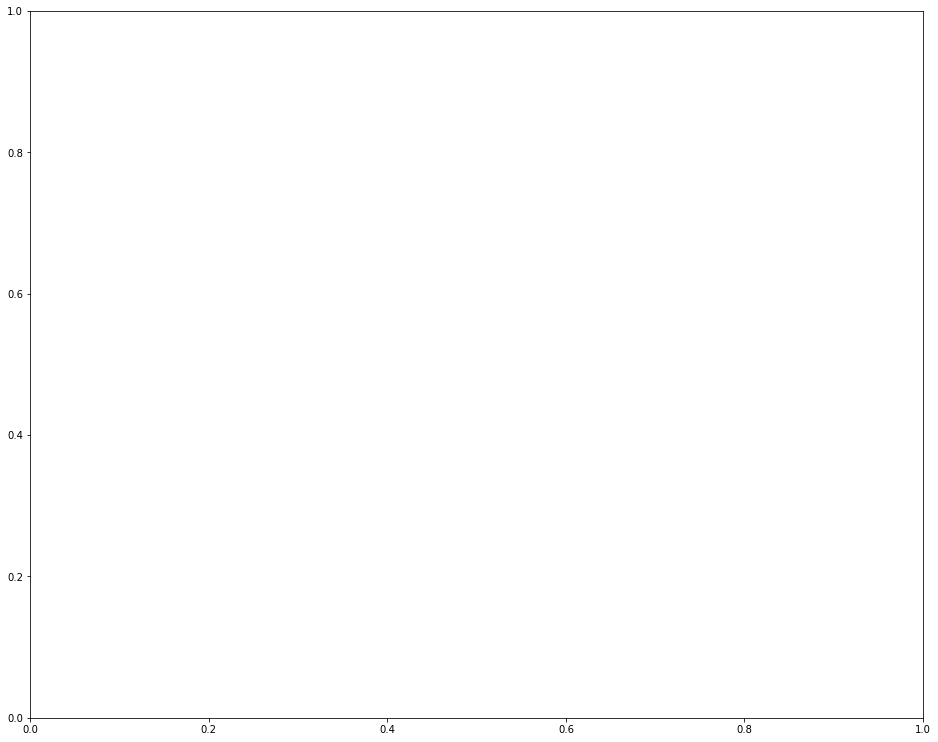

In [10]:
fig, ax = plt.subplots(figsize=(16,13))

for model_type, models in all_metrics["mse"].items():
    print("yuss")
    print(model_type)
    #if 'lstm' in model_type:
    if True:
        # single seed
        values = list(models['seed11111'].values())
        #print(values)
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=model_draw_style[model_type]['label'],
                color=model_draw_style[model_type]["single_color"], 
                #marker=model_draw_style[model_type]['marker'], 
                #markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
      # ensemble seed
#        values = list(models['ensemble'].values())
 #       bin_, cdf_ = ecdf(values)
  #      ax.plot(bin_,
   #             cdf_, 
    #            label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
     #           color=model_draw_style[model_type]['ensemble_color'], 
      #          linestyle=model_draw_style[model_type]['linestyle'])
    
ax.set_xlim(0, 1600)
ax.grid(True)
ax.legend(loc='upper left')
ax.set_xlabel('MSE', fontsize=14)
ax.set_ylabel('Cumulative density', fontsize=14)
ax.set_title("Effect of different sequence lengths", fontsize=18)

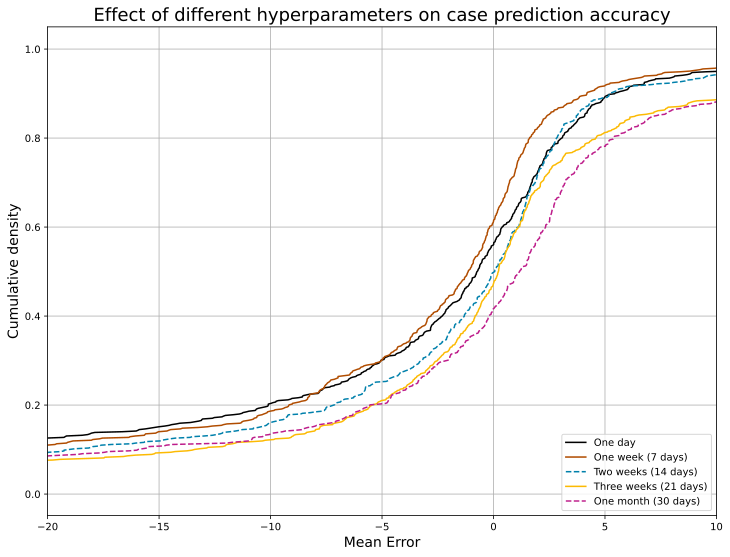

In [18]:
fig, ax = plt.subplots(figsize=(12, 9))

for model_type, models in all_metrics["me"].items():
    #if 'lstm' in model_type:
    if True:
        # single seed
        values = list(models['seed11111'].values())
        #print(values)
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=model_draw_style[model_type]['label'],
                color=model_draw_style[model_type]["single_color"], 
                #marker=model_draw_style[model_type]['marker'], 
                #markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
      # ensemble seed
#        values = list(models['ensemble'].values())
 #       bin_, cdf_ = ecdf(values)
  #      ax.plot(bin_,
   #             cdf_, 
    #            label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
     #           color=model_draw_style[model_type]['ensemble_color'], 
      #          linestyle=model_draw_style[model_type]['linestyle'])
    
ax.set_xlim(-20, 10)
ax.grid(True)
ax.legend(loc='lower right')
ax.set_xlabel('Mean Error', fontsize=14)
ax.set_ylabel('Cumulative density', fontsize=14)
ax.set_title("Effect of different hyperparameters on case prediction accuracy", fontsize=18)
fig.savefig("me_seqlens.png", bbox_inches='tight', dpi=300)

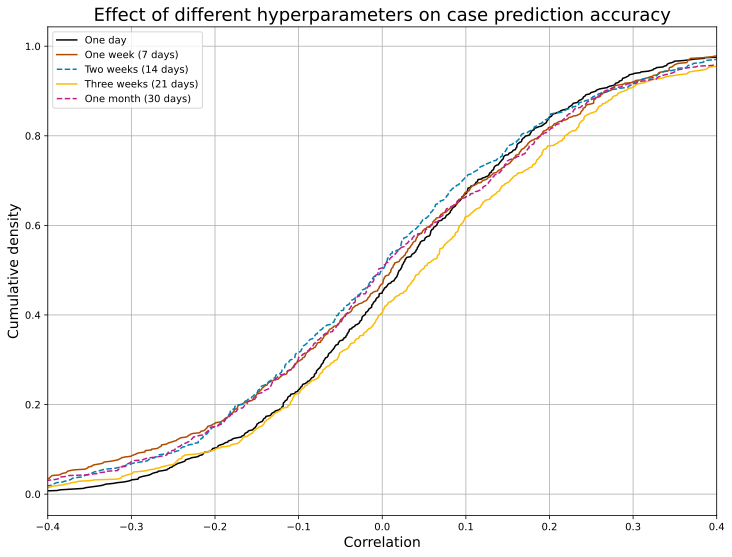

In [19]:
fig, ax = plt.subplots(figsize=(12,9))

for model_type, models in all_metrics["correlation"].items():
    #if 'lstm' in model_type:
    if True:
        # single seed
        values = list(models['seed11111'].values())
        #print(values)
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=model_draw_style[model_type]['label'],
                color=model_draw_style[model_type]["single_color"], 
                #marker=model_draw_style[model_type]['marker'], 
                #markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
      # ensemble seed
#        values = list(models['ensemble'].values())
 #       bin_, cdf_ = ecdf(values)
  #      ax.plot(bin_,
   #             cdf_, 
    #            label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
     #           color=model_draw_style[model_type]['ensemble_color'], 
      #          linestyle=model_draw_style[model_type]['linestyle'])
    
ax.set_xlim(-0.4, 0.4)
ax.grid(True)
ax.legend(loc='upper left')
ax.set_xlabel('Correlation', fontsize=14)
ax.set_ylabel('Cumulative density', fontsize=14)
ax.set_title("Effect of different hyperparameters on case prediction accuracy", fontsize=18)
fig.savefig("corr_seqlens.pdf", bbox_inches='tight')

In [ ]:
## Calculate statistical significance.

1. Calculate statistical significance between LSTM trained with and without static features using either MSE or NSE as loss function.

2. Calculate statistical significance between EA-LSTM and standard LSTM (with static features)

We always report the max, mean p-value between all possible seed combinations (n=8^2=64) as well as the p-value between the ensemble means

In [7]:
print("### NSE:")
print("With or without statics, optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_no_static_MSE', 
                                         model2='lstm_MSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nWith or without statics, optimized with NSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_no_static_NSE', 
                                         model2='lstm_NSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nEA-LSTM vs LSTM (with statics), optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_MSE', 
                                         model2='ealstm_MSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nEA-LSTM vs LSTM (with statics), optimized with NSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_NSE', 
                                         model2='ealstm_NSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

values1 = get_mean_basin_performance(all_metrics["NSE"], model="ealstm_NSE")
values1 = list(values1.values())
values2 = get_mean_basin_performance(all_metrics["NSE"], model="lstm_NSE")
values2 = list(values2.values())
d = get_cohens_d(values1, values2)
print(f"Effect size using Cohen's d is: d={d:.3f}")


print("\nEA-LSTM optimized with NSE vs. EA-LSTM optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='ealstm_NSE', 
                                         model2='ealstm_MSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nLSTM  without static features optimized with NSE vs. optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_no_static_MSE', 
                                         model2='lstm_no_static_NSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

### NSE:
With or without statics, optimized with MSE
Single models: p-value=1.15e-75
Ensemble mean: 3.99e-68

With or without statics, optimized with NSE
Single models: p-value=8.76e-81
Ensemble mean: 3.32e-75

EA-LSTM vs LSTM (with statics), optimized with MSE
Single models: p-value=6.07e-20
Ensemble mean: 2.90e-20

EA-LSTM vs LSTM (with statics), optimized with NSE
Single models: p-value=1.15e-28
Ensemble mean: 2.11e-26
Effect size using Cohen's d is: d=0.055

EA-LSTM optimized with NSE vs. EA-LSTM optimized with MSE
Single models: p-value=2.08e-01
Ensemble mean: 4.38e-01

LSTM  without static features optimized with NSE vs. optimized with MSE
Single models: p-value=4.34e-02
Ensemble mean: 8.09e-01


# Compare against benchmark models

Now we compare our model, the `EA-LSTM` optimized with `NSELoss`, against the set of benchmark models. Here, we only use the model results from the set of basins that were modeled by all models (the benchmark models and our models).

First, we have to calculate the metrics for all basins and benchmark models (or load the data from the precomputed file)

In [8]:
if not PRECOMPUTED_DATA:
    for metric in all_metrics.keys():
        tqdm.tqdm.write(f"Calculating metric: {metric}")
        all_metrics[metric]["benchmarks"] = eval_benchmark_models(netcdf_folder=BENCHMARK_DIR, 
                                                                  func=EVAL_FUNCS[metric])
else:
    print("Evaluation data of benchmark models already exist in pre-computed data")

Evaluation data of benchmark models already exist in pre-computed data


In [9]:
if not PRECOMPUTED_DATA:
    with open("all_metrics.p", "wb") as fp:
        pickle.dump(all_metrics, fp)
    print("Stored precomputed data in 'all_metrics.p'")

In [10]:
# find all basins modeled by all benchmarks
basins = frozenset(list(all_metrics["NSE"]["ealstm_NSE"]["ensemble"].keys()))
for model, results in all_metrics["NSE"]["benchmarks"].items():
    basins = basins.intersection(list(results.keys()))
len(basins)

447

In [11]:
# get subset of all metrics for these share basins
sub_metrics = {metric: defaultdict(dict) for metric in all_metrics.keys()}
for metric, model_metric in all_metrics.items():
    for model_type, models in model_metric.items():
        for model, results in models.items():
            sub_metrics[metric][model_type][model] = {}
            for basin, nse in results.items():
                if basin in basins:
                    sub_metrics[metric][model_type][model][basin] = nse

Text(0.5, 1.0, 'Benchmarking against CONUS-wide calibrated hydrological models')

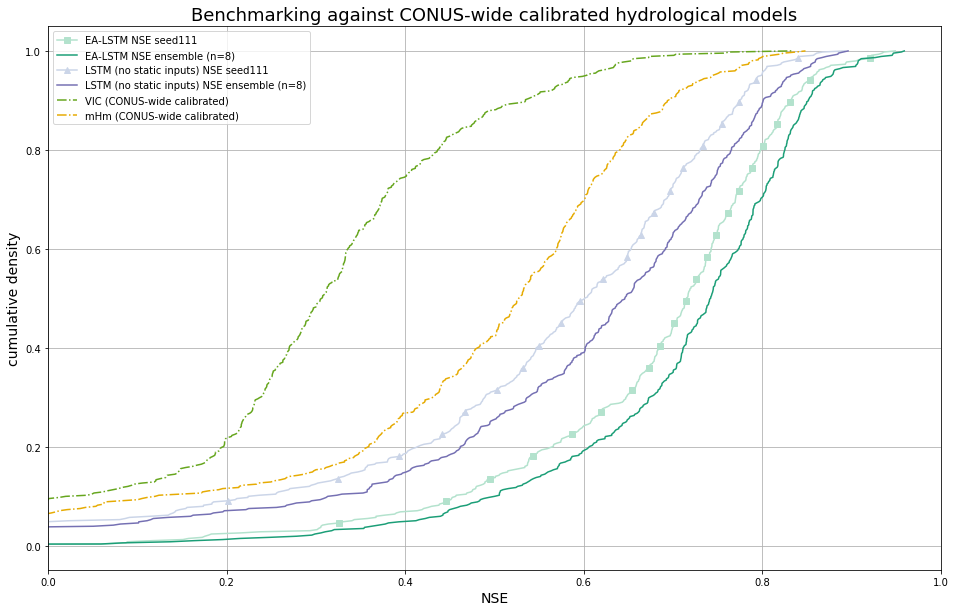

In [12]:
fig, ax = plt.subplots(figsize=(16,10))

for model_type, models in sub_metrics["NSE"].items():
    if (model_type == "ealstm_NSE") or (model_type == "lstm_no_static_NSE"):
        # single seed
        values = list(models['seed111'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=f"{model_draw_style[model_type]['label']} seed111",
                color=model_draw_style[model_type]["single_color"], 
                marker=model_draw_style[model_type]['marker'], 
                markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
        # ensemble seed
        values = list(models['ensemble'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_, 
                label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
                color=model_draw_style[model_type]['ensemble_color'], 
                linestyle=model_draw_style[model_type]['linestyle'])
    elif model_type == "benchmarks":
        for benchmark_model, benchmark_result in models.items():
            if "conus" in benchmark_model:
                values = list(benchmark_result.values())
                bin_, cdf_ = ecdf(values)
                ax.plot(bin_,
                        cdf_, 
                        label=model_draw_style[benchmark_model]['label'], 
                        color=model_draw_style[benchmark_model]['color'], 
                        linestyle=model_draw_style[benchmark_model]['linestyle'])
    
ax.set_xlim(0, 1)
ax.grid(True)
ax.legend(loc='upper left')
ax.set_xlabel('NSE', fontsize=14)
ax.set_ylabel('cumulative density', fontsize=14)
ax.set_title("Benchmarking against CONUS-wide calibrated hydrological models", fontsize=18)

In [13]:
vic_count = 0
mhm_count = 0
for basin in basins:
    lstm_nse = sub_metrics["NSE"]["ealstm_NSE"]["ensemble"][basin]
    if sub_metrics["NSE"]["benchmarks"]["VIC_conus"][basin] >= lstm_nse:
        vic_count += 1
    if sub_metrics["NSE"]["benchmarks"]["mHm_conus"][basin] >= lstm_nse:
        mhm_count += 1
        
print(f"VIC is better (or equal) than EA-LSTM ensemble mean in {vic_count}/{len(basins)} basins")
print(f"mHm is better (or equal) than EA-LSTM ensemble mean in {mhm_count}/{len(basins)} basins")

VIC is better (or equal) than EA-LSTM ensemble mean in 2/447 basins
mHm is better (or equal) than EA-LSTM ensemble mean in 16/447 basins


Text(0.5, 1.0, 'Benchmarking against basin-wise calibrated hydrological models')

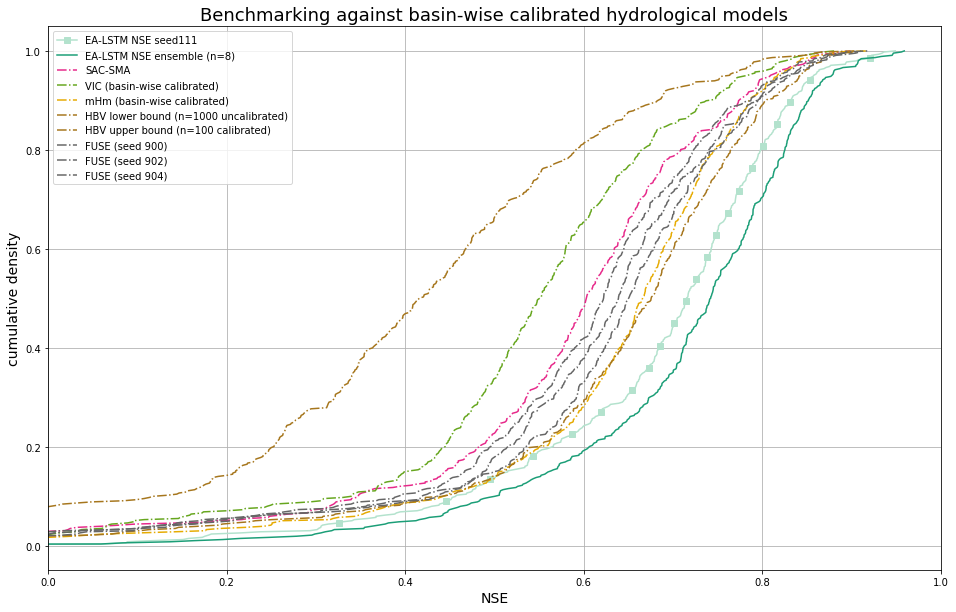

In [14]:
fig, ax = plt.subplots(figsize=(16,10))

for model_type, models in sub_metrics["NSE"].items():
    if model_type == "ealstm_NSE":
        # single seed
        values = list(models['seed111'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=f"{model_draw_style[model_type]['label']} seed111",
                color=model_draw_style[model_type]["single_color"], 
                marker=model_draw_style[model_type]['marker'], 
                markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
        # ensemble seed
        values = list(models['ensemble'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_, 
                label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
                color=model_draw_style[model_type]['ensemble_color'], 
                linestyle=model_draw_style[model_type]['linestyle'])
    elif model_type == "benchmarks":
        for benchmark_model, benchmark_result in models.items():
            if not "conus" in benchmark_model:
                values = list(benchmark_result.values())
                bin_, cdf_ = ecdf(values)
                ax.plot(bin_,
                        cdf_, 
                        label=model_draw_style[benchmark_model]['label'], 
                        color=model_draw_style[benchmark_model]['color'], 
                        linestyle=model_draw_style[benchmark_model]['linestyle'])
    
ax.set_xlim(0, 1)
ax.grid(True)
ax.legend(loc='upper left')
ax.set_xlabel('NSE', fontsize=14)
ax.set_ylabel('cumulative density', fontsize=14)
ax.set_title("Benchmarking against basin-wise calibrated hydrological models", fontsize=18)

In [15]:
data = []
single_model = {'model': 'EA-LSTM with NSE', 'ensemble': False}
ensemble_mean = {'model': 'EA-LSTM with NSE', 'ensemble': True}
# get EA-LSTM stats for all metrics
for metric, metric_data in sub_metrics.items():
    
    # average over single models
    seeds = [k for k in metric_data["ealstm_NSE"].keys() if "seed" in k]
    seed_vals = defaultdict(list)
    for seed in seeds:
        values = list(metric_data["ealstm_NSE"][seed].values())
        seed_vals[f"{metric} median"].append(np.median(values))
        if metric == "NSE":
            seed_vals[f"{metric} mean"].append(np.mean(values))
            seed_vals["failures"].append(len([v for v in values if v <= 0]))
        single_model[f"{metric} median"] = np.mean(seed_vals[f"{metric} median"])
        single_model[f"{metric} median std"] = np.std(seed_vals[f"{metric} median"])
        if metric == "NSE":
            single_model[f"{metric} mean"] = np.mean(seed_vals[f"{metric} mean"])
            single_model[f"{metric} mean std"] = np.std(seed_vals[f"{metric} mean"])
            single_model[f"failures"] = np.mean(seed_vals["failures"])
            single_model[f"failures std"] = np.std(seed_vals["failures"])
            
    # ensemble mean
    values = list(metric_data["ealstm_NSE"]["ensemble"].values())
    ensemble_mean[f"{metric} median"] = np.median(values)
    if metric == "NSE":
        ensemble_mean["NSE mean"] = np.mean(values)
        ensemble_mean["failures"] = len([v for v in values if v <= 0])
        
data.append(single_model)
data.append(ensemble_mean)
        
# benchmark models:
for model in model_draw_style.keys():
    if "lstm" in model:
        continue
    model_data = {"model": model_draw_style[model]["label"], "ensemble": False}
    for metric, metric_data in sub_metrics.items():
        values = list(metric_data["benchmarks"][model].values())
        model_data[f"{metric} median"] = np.median(values)
        if metric == "NSE":
            model_data["NSE mean"] = np.mean(values)
            model_data["failures"] = len([v for v in values if v <= 0])
            
    data.append(model_data)
        
df = pd.DataFrame(data)
df = df.set_index(keys=["model", "ensemble"])
df

FHV median  FHV median std  \
model                                 ensemble                               
EA-LSTM with NSE                      False     -16.912275        1.148501   
                                      True      -18.140744             NaN   
SAC-SMA                               False     -20.356397             NaN   
VIC (basin-wise calibrated)           False     -28.139453             NaN   
VIC (CONUS-wide calibrated)           False     -56.483333             NaN   
mHm (basin-wise calibrated)           False     -18.640055             NaN   
mHm (CONUS-wide calibrated)           False     -40.178353             NaN   
HBV lower bound (n=1000 uncalibrated) False     -41.859371             NaN   
HBV upper bound (n=100 calibrated)    False     -18.490541             NaN   
FUSE (seed 900)                       False     -18.934932             NaN   
FUSE (seed 902)                       False     -19.360154             NaN   
FUSE (seed 904)                       False     -21.406883             NaN   

                                                FLV median  FLV median std  \
model                                 ensemble                               
EA-LSTM with NSE                      False       2.007990        7.588762   
                                      True       31.937520             NaN   
SAC-SMA                               False      37.408956             NaN   
VIC (basin-wise calibrated)           False     -69.958477             NaN   
VIC (CONUS-wide calibrated)           False      17.362716             NaN   
mHm (basin-wise calibrated)           False      11.433140             NaN   
mHm (CONUS-wide calibrated)           False      36.399823             NaN   
HBV lower bound (n=1000 uncalibrated) False      23.882161             NaN   
HBV upper bound (n=100 calibrated)    False      18.340945             NaN   
FUSE (seed 900)                       False     -11.399515             NaN   
FUSE (seed 902)                       False     -33.153355             NaN   
FUSE (seed 904)                       False     -66.744506             NaN   

                                                FMS median  FMS median std  \
model                                 ensemble                               
EA-LSTM with NSE                      False     -10.012182        1.724323   
                                      True      -11.290716             NaN   
SAC-SMA                               False     -14.282640             NaN   
VIC (basin-wise calibrated)           False      -6.561743             NaN   
VIC (CONUS-wide calibrated)           False     -27.989592             NaN   
mHm (basin-wise calibrated)           False      -7.221696             NaN   
mHm (CONUS-wide calibrated)           False     -30.352985             NaN   
HBV lower bound (n=1000 uncalibrated) False     -15.942301             NaN   
HBV upper bound (n=100 calibrated)    False     -24.935201             NaN   
FUSE (seed 900)                       False      -5.091586             NaN   
FUSE (seed 902)                       False       9.597864             NaN   
FUSE (seed 904)                       False      15.490393             NaN   

                                                NSE mean  NSE mean std  \
model                                 ensemble                           
EA-LSTM with NSE                      False     0.673587      0.006329   
                                      True      0.705011           NaN   
SAC-SMA                               False     0.563865           NaN   
VIC (basin-wise calibrated)           False     0.518387           NaN   
VIC (CONUS-wide calibrated)           False     0.167402           NaN   
mHm (basin-wise calibrated)           False     0.627171           NaN   
mHm (CONUS-wide calibrated)           False     0.441506           NaN   
HBV lower bound (n=1000 uncalibrated) False     0.237386           NaN   
HBV upper bound (n=100 calibr

In [16]:
df.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th></th>\n      <th>FHV median</th>\n      <th>FHV median std</th>\n      <th>FLV median</th>\n      <th>FLV median std</th>\n      <th>FMS median</th>\n      <th>FMS median std</th>\n      <th>NSE mean</th>\n      <th>NSE mean std</th>\n      <th>NSE median</th>\n      <th>NSE median std</th>\n      <th>alpha_nse median</th>\n      <th>alpha_nse median std</th>\n      <th>beta_nse median</th>\n      <th>beta_nse median std</th>\n      <th>failures</th>\n      <th>failures std</th>\n    </tr>\n    <tr>\n      <th>model</th>\n      <th>ensemble</th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th rowspan

In [16]:
for metric in sub_metrics.keys():
    print(f"\n\n#### {metric}")
    print(f"Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)")
    ealstm_perf = get_mean_basin_performance(sub_metrics[metric], model="ealstm_NSE")
    _, p_val_single = wilcoxon(list(ealstm_perf.values()),
                               list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()))
    _, p_val_ensemble = wilcoxon(list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()), 
                                 list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"For single models: {p_val_single:.2e}")
    print(f"For ensemble mean {p_val_ensemble:.2e}")
    d_single = get_cohens_d(list(ealstm_perf.values()),
                            list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()))
    d_ensemble = get_cohens_d(list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()), 
                              list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"Effect size: Single model d={d_single:.3f}, ensemble mean d={d_ensemble:.3f}")


    print(f"\nComparison between EA-LSTM (optimized with NSE) and HBV (upper limit)")
    _, p_val_single = wilcoxon(list(ealstm_perf.values()),
                               list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()))
    _, p_val_ensemble = wilcoxon(list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()), 
                                 list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"For single models: {p_val_single:.2e}")
    print(f"For ensemble mean {p_val_ensemble:.2e}")
    d_single = get_cohens_d(list(ealstm_perf.values()),
                            list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()))
    d_ensemble = get_cohens_d(list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()), 
                              list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"Effect size: Single model d={d_single:.3f}, ensemble mean d={d_ensemble:.3f}")



#### NSE
Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)
For single models: 4.29e-06
For ensemble mean 1.01e-13
Effect size: Single model d=0.256, ensemble mean d=0.445

Comparison between EA-LSTM (optimized with NSE) and HBV (upper limit)
For single models: 1.90e-04
For ensemble mean 6.21e-11
Effect size: Single model d=0.224, ensemble mean d=0.404


#### alpha_nse
Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)
For single models: 1.84e-01
For ensemble mean 7.82e-01
Effect size: Single model d=0.049, ensemble mean d=0.047

Comparison between EA-LSTM (optimized with NSE) and HBV (upper limit)
For single models: 3.88e-02
For ensemble mean 5.33e-01
Effect size: Single model d=0.106, ensemble mean d=0.016


#### beta_nse
Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)
For single models: 3.24e-03
For ensemble mean 3.24e-03
Effect size: Single model d=0.189, ensemble mean d=0.189

Comparison be

In [32]:
obs = np.array([0, 1, 2, 3, 3])
sim = np.array([0, 1, 2, 3, 4])
me_val = np.mean(obs - sim)

In [33]:
me_val

-0.2

In [38]:
corr_val = np.corrcoef(obs, sim)[1][0]

In [40]:
corr_val

0.9701425001453319